In [11]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [17]:
dataset_path = 'pictures'
IMG_WIDTH, IMG_HEIGHT = 224, 224

In [18]:
datagen = ImageDataGenerator(
    rescale=1./255,      
    validation_split=0.3    
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),      
    batch_size=32,
    class_mode='categorical',
    subset='training' 
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='categorical',
    subset='validation' 
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.3
)

test_generator = test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 2107 images belonging to 31 classes.
Found 876 images belonging to 31 classes.
Found 876 images belonging to 31 classes.


In [58]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Abudefduf vaigiensis
1 : Acanthurus sohal
2 : Acropora sp
3 : Amphiprion bicinctus
4 : Aurelia aurita
5 : Caesio suevica
6 : Caranx sp
7 : Carcharhinus amblyrhynchos
8 : Cephalopholis miniata
9 : Chaetodon auriga
10 : Chelidonura flavolobata
11 : Chelonia mydas
12 : Choriaster granulatus
13 : Cyclichthys spilostylus
14 : Epinephelus fasciatus
15 : Epinephelus polyphekadion
16 : Goniobranchus annulatus
17 : Heniochus intermedius
18 : Heterocentrotus mamillatus
19 : Holacanthus ciliaris
20 : Holothuria atra
21 : Iago omanensis
22 : Millepora dichotoma
23 : Myrichthys maculosus
24 : Octopus vulgaris
25 : Plotosus lineatus
26 : Rhincodon typus
27 : Scarus sp
28 : Seriolina nigrofasciata
29 : Sphyraena barracuda
30 : Stegostoma tigrinum


In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

base_model.trainable = False

for layer in base_model.layers[-10:]:
    if layer == BatchNormalization:
        continue
    layer.trainable = True


In [24]:
model = Sequential([
    base_model,
    Flatten(),  
    Dense(256, activation='relu'),  
    Dense(128, activation='relu'), 
    Dropout(0.5),  
    Dense(31, activation='softmax') 
])

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

model.build(input_shape=(None, *input_shape))


In [25]:
print(model.summary())

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 31)             │         3,999 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,174,367 (80.77 MB)

 Trainable params: 20,028,959 (76.40 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

None


In [44]:
model.summary(line_length=150, expand_nested=True, show_trainable=True)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━
┃ Layer (type)                                              ┃ Output Shape                                  ┃      
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━
│ vgg16 (Functional)                                        │ (None, 7, 7, 512)                             │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ input_layer_3 (InputLayer)                           │ (None, 224, 224, 3)                           │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block1_conv1 (Conv2D)                                │ (None, 224, 224, 64)                          │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block1_conv2 (Conv2D)                                │ (None, 224, 224, 64)                          │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block1_pool (MaxPooling2D)                           │ (None, 112, 112, 64)                          │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block2_conv1 (Conv2D)                                │ (None, 112, 112, 128)                         │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block2_conv2 (Conv2D)                                │ (None, 112, 112, 128)                         │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block2_pool (MaxPooling2D)                           │ (None, 56, 56, 128)                           │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block3_conv1 (Conv2D)                                │ (None, 56, 56, 256)                           │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block3_conv2 (Conv2D)                                │ (None, 56, 56, 256)                           │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block3_conv3 (Conv2D)                                │ (None, 56, 56, 256)                           │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block3_pool (MaxPooling2D)                           │ (None, 28, 28, 256)                           │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block4_conv1 (Conv2D)                                │ (None, 28, 28, 512)                           │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block4_conv2 (Conv2D)                                │ (None, 28, 28, 512)                           │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block4_conv3 (Conv2D)                                │ (None, 28, 28, 512)                           │      
├───────────────────────────────────────────────────────────┼───────────────────────────────────────────────┼──────
│    └ block4_pool (MaxPooling2D)                           │ (None, 14, 14, 512)                           │      
├───────────────────────────────────────────────────────

 Total params: 61,232,287 (233.58 MB)

 Trainable params: 20,028,959 (76.40 MB)

 Non-trainable params: 1,145,408 (4.37 MB)

 Optimizer params: 40,057,920 (152.81 MB)

In [26]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CategoricalCrossentropy(), metrics=['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=3)

history = model.fit(
    train_generator, 
    epochs=20, 
    validation_data=validation_generator, 
    callbacks=[reduce_lr]
)

Epoch 1/20


c:\Users\kiril\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


66/66 ━━━━━━━━━━━━━━━━━━━━ 399s 6s/step - accuracy: 0.0535 - loss: 3.4861 - val_accuracy: 0.1187 - val_loss: 3.1957 - learning_rate: 1.0000e-04
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 433s 7s/step - accuracy: 0.1111 - loss: 3.1780 - val_accuracy: 0.1838 - val_loss: 2.9537 - learning_rate: 1.0000e-04
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 417s 6s/step - accuracy: 0.1827 - loss: 2.9389 - val_accuracy: 0.3265 - val_loss: 2.5634 - learning_rate: 1.0000e-04
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 391s 6s/step - accuracy: 0.2802 - loss: 2.5459 - val_accuracy: 0.3402 - val_loss: 2.3543 - learning_rate: 1.0000e-04
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 392s 6s/step - accuracy: 0.3866 - loss: 2.2323 - val_accuracy: 0.3813 - val_loss: 2.2424 - learning_rate: 1.0000e-04
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 392s 6s/step - accuracy: 0.4112 - loss: 2.1111 - val_accuracy: 0.4897 - val_loss: 1.9011 - learning_rate: 1.0000e-04
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 392s 6s/step - accuracy: 0.5304 - loss: 1.7

In [27]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc * 100:.2f}%")


28/28 ━━━━━━━━━━━━━━━━━━━━ 77s 3s/step - accuracy: 0.6569 - loss: 1.9341
Test Loss: 2.0083
Test Accuracy: 65.18%


In [59]:
model.save_weights('ecoralVGG16.weights.h5')

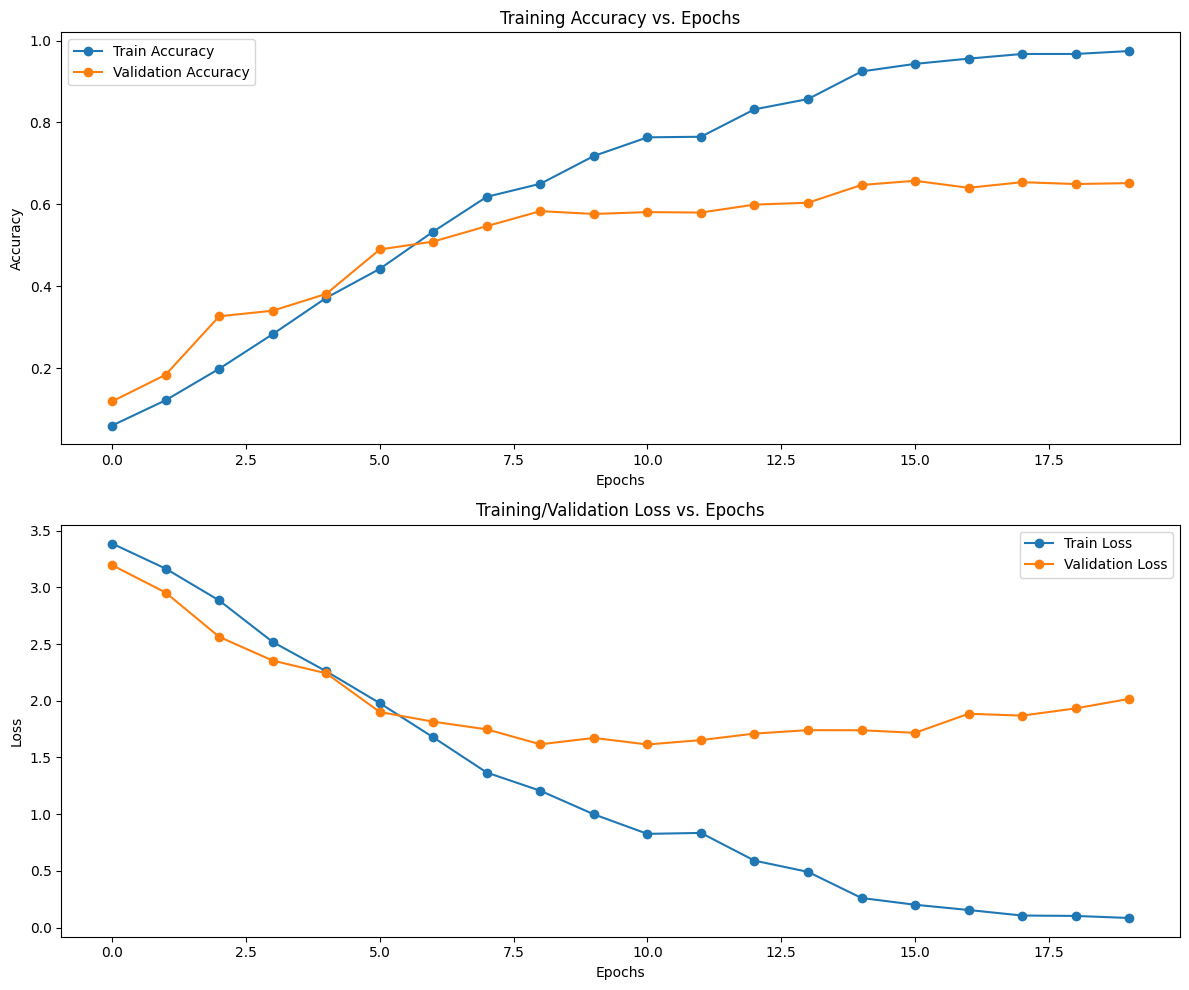

In [30]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step


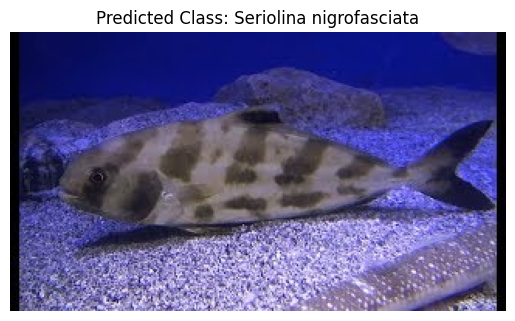

The predicted class is: Seriolina nigrofasciata


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def predict_image_class(image_path, model, train_generator, IMG_WIDTH=224, IMG_HEIGHT=224):

    img = load_img(image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))  
    img_array = img_to_array(img)  
    img_array = np.expand_dims(img_array, axis=0)  
    img_array = img_array / 255.0 

    # Predict the class
    predictions = model.predict(img_array)  
    predicted_class_index = np.argmax(predictions, axis=1)  

    class_labels = list(train_generator.class_indices.keys())  
    predicted_class_label = class_labels[predicted_class_index[0]]  

    plt.imshow(load_img(image_path))
    plt.title(f"Predicted Class: {predicted_class_label}")
    plt.axis('off') 
    plt.show()

    return predicted_class_label

image_path = 'img1.jpg'
predicted_class = predict_image_class(image_path, model, train_generator)
print(f"The predicted class is: {predicted_class}")


In [39]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1) 
y_true = test_generator.classes  


28/28 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step


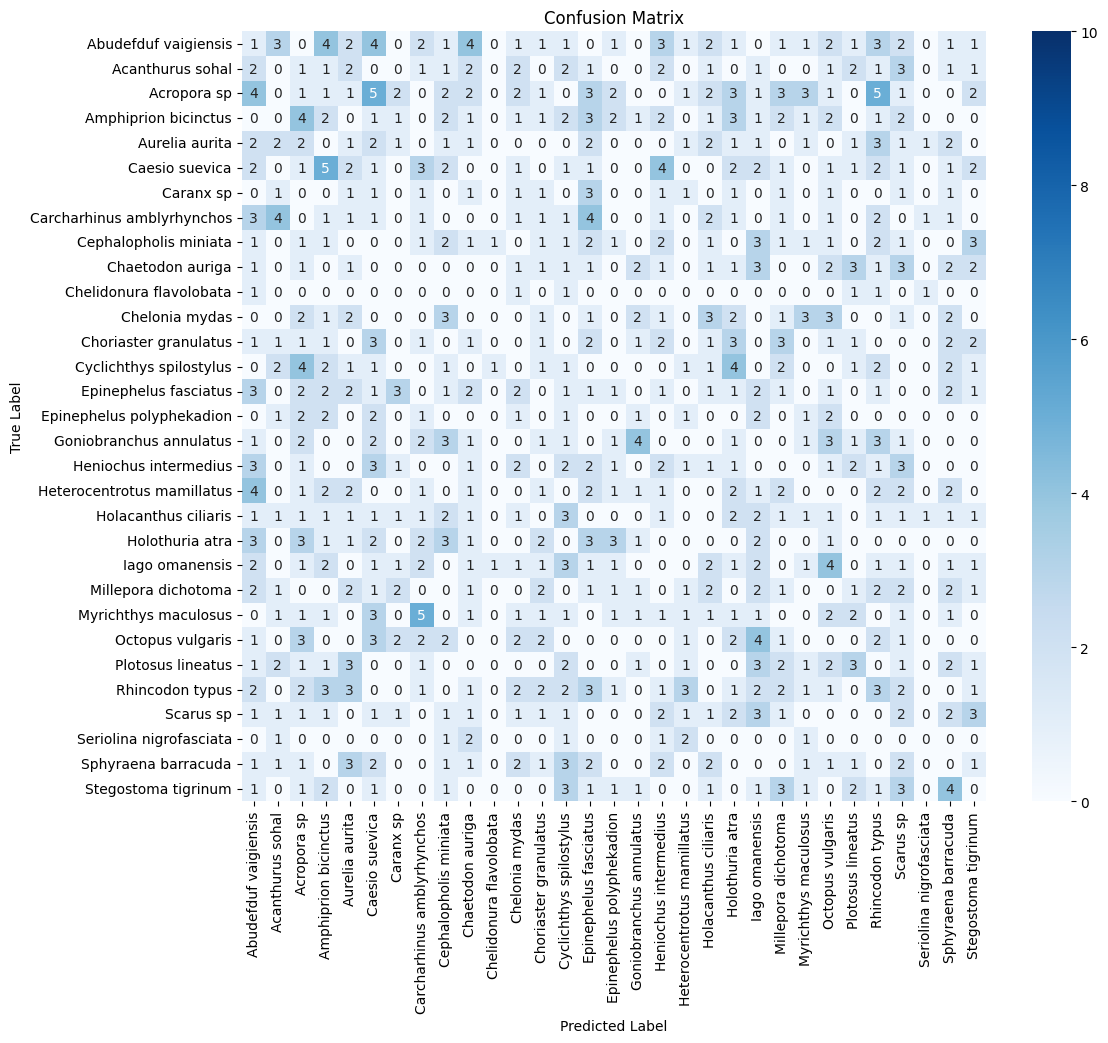

In [55]:

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=test_generator.class_indices.keys(), 
            yticklabels=test_generator.class_indices.keys(),
            vmax=10)  # Set vmax to 10 to make the darkest blue color correspond to 10
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


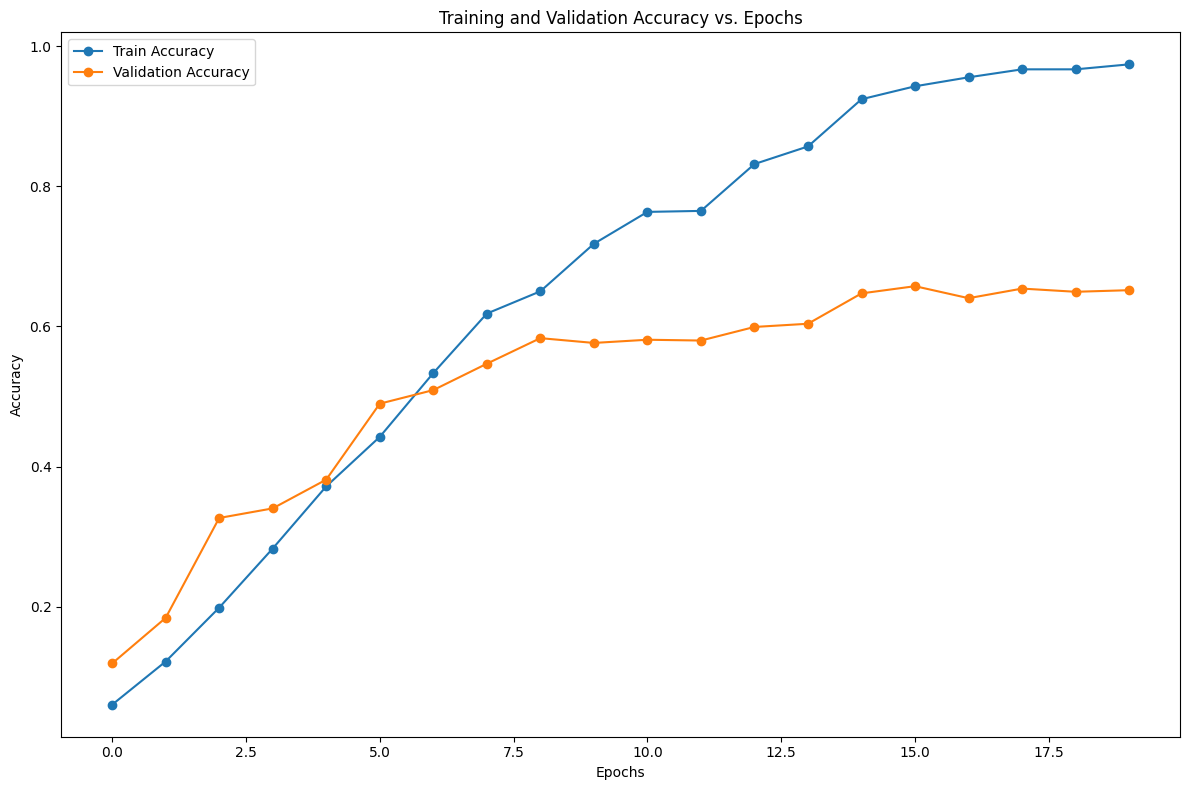

In [57]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig, ax = plt.subplots(figsize=(12, 8)) 

ax.set_title('Training and Validation Accuracy vs. Epochs')
ax.plot(train_accuracy, 'o-', label='Train Accuracy')
ax.plot(val_accuracy, 'o-', label='Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(loc='best')

plt.tight_layout()
plt.show()
